In [1]:
import json
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt

from diskit.components.layer import *
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit.compiler import transpile

from diskit_updated.circuit_remapper import *
from ionq.compile_native import compile_to_ionq_native_gates

In [2]:
with open("error_datasheets/Harmony_IonQ_11qubits.json", 'r') as f:
    ionq_11q_datasheet = json.load(f)
with open("error_datasheets/Aria1_IonQ_25qubits.json", 'r') as f:
    ionq_25q_datasheet = json.load(f)
with open("error_datasheets/Forte1_IonQ_36qubits.json", 'r') as f:
    ionq_36q_datasheet = json.load(f)

with open("error_datasheets/IBM_Kyiv_127qubits.json", 'r') as f:
    ibm_kyiv_127q_datasheet = json.load(f)

In [3]:
# GENERAL GATES
measure_gate = 'measure'
reset_gate = 'reset'

# 1. IONQ -> Only valid gates are:
#   - GPI: Puerta IonQ GPi
#   - GPI2: Puerta IonQ GPi2.
#   - MS: Puerta IonQ de Mølmer-Sørenson.

#GPI = Rz(2ϕ)X
#GPI2 = Rz(ϕ)Rx(π/2)Rz(−ϕ)
ionq_valid_1qgates = ['gpi', 'gpi2']
ionq_valid_2qgates = ['ms']
ionq_valid_gates = ionq_valid_1qgates + ionq_valid_2qgates

# 2. IBMQ Kyiv -> ECR, ID, RZ, SX, X
ibmq_valid_1qgates = ["id", "rz", "sx", "x"]
ibmq_valid_2qgates = ["ecr"]
ibmq_valid_gates = ibmq_valid_1qgates + ibmq_valid_2qgates

# CIRCUIT TO SIMULATE

In [4]:
def initialize_circuit(qregs = None, n_qubits = None):
    if qregs is None:
        return QuantumCircuit(n_qubits)
    
    qregs_list = qregs.values()
    return QuantumCircuit(*qregs_list)


def get_circuit_max30qubits(qregs = None, n_qubits = None):
    qc = initialize_circuit(qregs, n_qubits)
    
    qc.h(0)
    qc.cx(0, 1)

    return qc
    # WRITE CODE HERE

def get_circuit_max120qubits(qregs = None, n_qubits = None):
    qc = initialize_circuit(qregs, n_qubits)
    qc.h(0)
    qc.cx(0, 1)
    
    return qc
    # WRITE CODE HERE

# DISTRIBUTED UTILITIES

In [5]:
def create_distributed_topology(n_nodes, qubits_per_qnode):
    circuit_topo = Topology()
    circuit_topo.create_qmap(n_nodes, [qubits_per_qnode for _ in range(n_nodes)], "qnode")

    qregs = {}

    for qpu in circuit_topo.qmap:
        reg = circuit_topo.qmap[qpu][0]._register
        qregs[reg.name] = reg
    for qpu in circuit_topo.emap:
        reg = circuit_topo.emap[qpu]._register
        qregs[reg.name] = reg
    
    return circuit_topo, qregs

In [6]:
def remap_circuit(qc, circuit_topo, qregs, measure=False):
    remapper = CircuitRemapper(circuit_topo)
    dist_circ = remapper.remap_circuit(qc)

    if measure:
        measure_reg_q0 = ClassicalRegister(len(qregs['qnode0']), name="measure_qnode0")
        measure_reg_q1 = ClassicalRegister(len(qregs['qnode1']), name="measure_qnode1")
        dist_circ.add_register(measure_reg_q0)
        dist_circ.add_register(measure_reg_q1)
        #dist_circ.barrier()
        dist_circ.measure(qregs['qnode0'], measure_reg_q0)
        dist_circ.measure(qregs['qnode1'], measure_reg_q1)

    return dist_circ

# ANALISIS CIRCUITOS

- Calculo de la fidelidad total

In [7]:
def calculate_total_fidelity(
    count_operations: OrderedDict, 
    op_list_1q: list[str], 
    op_list_2q: list[str],
    config_json: dict[str, object]
) -> float:
    
    total_error = 0
    fidelity_config = config_json["fidelity"]

    for op_1q in op_list_1q:
        if op_1q in count_operations:
            total_error += count_operations[op_1q] * (1 - fidelity_config['1Q']['mean'])

    for op_2q in op_list_2q:
        if op_2q in count_operations:
            total_error += count_operations[op_2q] * (1 - fidelity_config['2Q']['mean'])

    if measure_gate in count_operations:
        total_error += count_operations[measure_gate] * (1 - fidelity_config['readout']['mean'])

    return 1 - total_error

- Calculo del tiempo total de execución

In [8]:
def calculate_total_timing_error(
    count_operations: OrderedDict, 
    op_list_1q: list[str], 
    op_list_2q: list[str],
    config_json: dict[str, object]
) -> float:
    print(count_operations)
    timing_error = 0
    timing_config = config_json["timing (us)"]

    for op_1q in op_list_1q:
        if op_1q in count_operations:
            timing_error += count_operations[op_1q] * timing_config['1Q']

    for op_2q in op_list_2q:
        if op_2q in count_operations:
            timing_error += count_operations[op_2q] * timing_config['2Q']

    if measure_gate in count_operations:
        timing_error += count_operations[measure_gate] * timing_config['readout']

    if reset_gate in count_operations:
        timing_error += count_operations[reset_gate] * timing_config['reset']
    
    return timing_error

- Benchmark de diferentes máquinas y algoritmos:

In [9]:
def benchmark_distributed_execution(
    benchmark_machine_list: list[tuple[dict[str, object], int, int]],
    circuit_function
):
    dist_circuits = []
    output_circuits = []

    qubits_list = []
    fidelity_list = []
    timing_error_list = []

    for machine_type_config, n_qnodes, qubits_per_qnode in benchmark_machine_list:
        if n_qnodes == 1:
            dist_circuit = circuit_function(n_qubits=qubits_per_qnode)
        else:
            circuit_topo, qregs = create_distributed_topology(n_nodes=n_qnodes, qubits_per_qnode=qubits_per_qnode)
            initial_circuit = circuit_function(qregs=qregs)
            dist_circuit = remap_circuit(qc=initial_circuit, circuit_topo=circuit_topo, qregs=qregs)
        
        if machine_type_config["machine"] == "ionq":
            output_circuit = compile_to_ionq_native_gates(dist_circuit, check=False)
        else:
            output_circuit = transpile(dist_circuit, basis_gates=ibmq_valid_gates)

        dist_circuits.append(dist_circuit)
        output_circuits.append(output_circuit)
        qubits_list.append(qubits_per_qnode)

        count_operations = output_circuit.count_ops()

        if machine_type_config["machine"] == "ionq":
            fidelity_list.append(calculate_total_fidelity(count_operations, ionq_valid_1qgates, 
                                                        ionq_valid_2qgates, machine_type_config))
            timing_error_list.append(calculate_total_timing_error(count_operations, ionq_valid_1qgates, 
                                                        ionq_valid_2qgates, machine_type_config))
        elif machine_type_config["machine"] == "ibmq":
            fidelity_list.append(calculate_total_fidelity(count_operations, ibmq_valid_1qgates, 
                                                        ibmq_valid_2qgates, machine_type_config))
            timing_error_list.append(calculate_total_timing_error(count_operations, ibmq_valid_1qgates, 
                                                        ibmq_valid_2qgates, machine_type_config))
            
    return dist_circuits, output_circuits, qubits_list, fidelity_list, timing_error_list

# EXECUTION IONQ MACHINES WITH 30 QUBIT ALGORITHM

In [10]:
dist_circuits, output_circuits, qubits_list, fidelity_list, timing_error_list = benchmark_distributed_execution(
    benchmark_machine_list=[
        (ionq_11q_datasheet, 3, 10), 
        (ionq_25q_datasheet, 2, 24), 
        (ionq_36q_datasheet, 1, 36)
    ],
    circuit_function=get_circuit_max30qubits
)

OrderedDict([('gpi2', 5), ('gpi', 1), ('ms', 1)])
OrderedDict([('gpi2', 5), ('gpi', 1), ('ms', 1)])
OrderedDict([('gpi2', 5), ('gpi', 1), ('ms', 1)])


(0.9405999999999998, 0.9932)

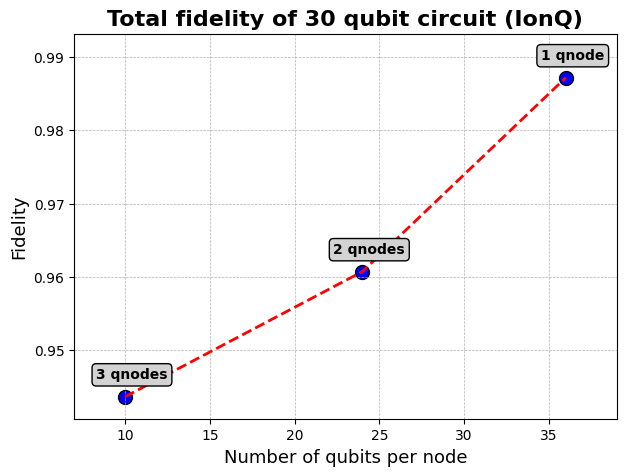

In [11]:
labels = ["3 qnodes", "2 qnodes", "1 qnode"]

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(7, 5))

# Calcular la línea de tendencia
coefficients = np.polyfit(qubits_list, fidelity_list, 2)
trendline = np.poly1d(coefficients)

# Configuración del gráfico
ax.scatter(qubits_list, fidelity_list, color='blue', s=100, edgecolors='k', label='Datos')
ax.plot(qubits_list, trendline(qubits_list), color='red', linestyle='--', linewidth=2, label='Línea de tendencia')

# Añadir etiquetas a los puntos
for i, txt in enumerate(labels):
    ax.annotate(txt, (qubits_list[i], fidelity_list[i] + 0.0015), textcoords="offset points", xytext=(5,5), ha='center',
                fontsize=10, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='lightgray'))

# Títulos y etiquetas
ax.set_title('Total fidelity of 30 qubit circuit (IonQ)', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of qubits per node', fontsize=13)
ax.set_ylabel('Fidelity', fontsize=13)

# Líneas de cuadrícula
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Get the x, y limits
xmin, xmax = min(qubits_list), max(qubits_list)
ymin, ymax = min(fidelity_list), max(fidelity_list)
plt.xlim(xmin-3, xmax+3)
plt.ylim(ymin-0.003, ymax + 0.006)

(185.5, 1973.5)

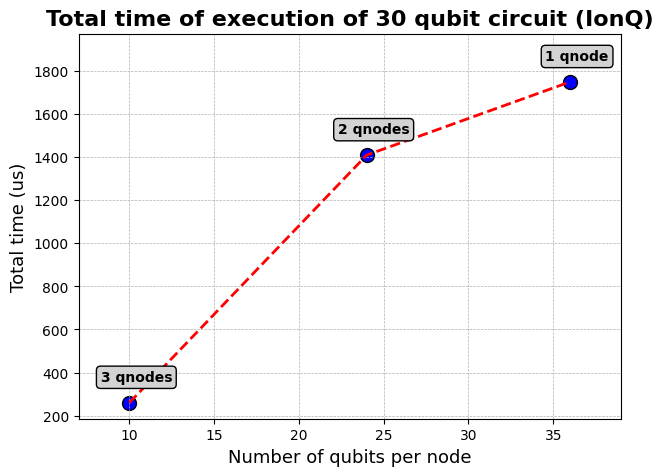

In [12]:
labels = ["3 qnodes", "2 qnodes", "1 qnode"]
# Get the x, y limits
xmin, xmax = min(qubits_list), max(qubits_list)
ymin, ymax = min(timing_error_list), max(timing_error_list)
range_values_y = ymax - ymin

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(7, 5))

# Calcular la línea de tendencia
coefficients = np.polyfit(qubits_list, timing_error_list, 2)
trendline = np.poly1d(coefficients)

# Configuración del gráfico
ax.scatter(qubits_list, timing_error_list, color='blue', s=100, edgecolors='k', label='Datos')
ax.plot(qubits_list, trendline(qubits_list), color='red', linestyle='--', linewidth=2, label='Línea de tendencia')

# Añadir etiquetas a los puntos
for i, txt in enumerate(labels):
    ax.annotate(txt, (qubits_list[i], timing_error_list[i] + range_values_y * 0.045), textcoords="offset points", xytext=(5,5), ha='center',
                fontsize=10, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='lightgray'))

# Títulos y etiquetas
ax.set_title('Total time of execution of 30 qubit circuit (IonQ)', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of qubits per node', fontsize=13)
ax.set_ylabel('Total time (us)', fontsize=13)

# Líneas de cuadrícula
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.xlim(xmin-3, xmax+3)
plt.ylim(ymin - range_values_y * 0.05, ymax + range_values_y * 0.15)

#### EXAMPLE OF IONQ COMPILATION

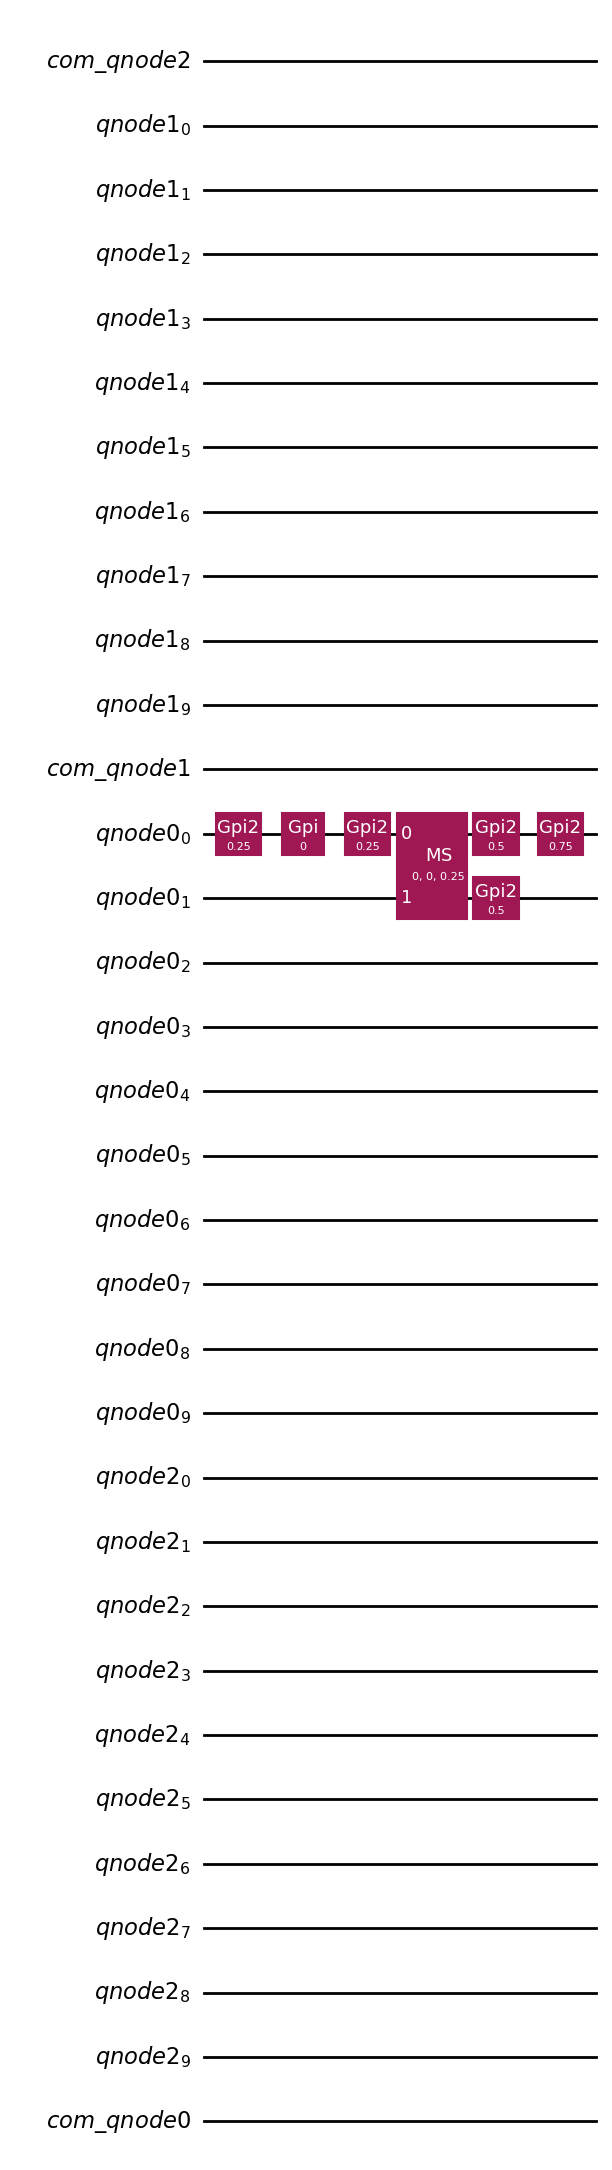

In [13]:
output_circuits[0].draw(output='mpl')

# COMPARISON IONQ V.S IBMQ MACHINES WITH 120 QUBIT ALGORITHM

In [14]:
dist_circuits, output_circuits, qubits_list, fidelity_list, timing_error_list = benchmark_distributed_execution(
    benchmark_machine_list=[
        (ionq_11q_datasheet, 12, 10), 
        (ionq_25q_datasheet, 5, 24), 
        (ionq_36q_datasheet, 4, 35),
        (ibm_kyiv_127q_datasheet, 1, 127)
    ],
    circuit_function=get_circuit_max120qubits
)

OrderedDict([('gpi2', 5), ('gpi', 1), ('ms', 1)])
OrderedDict([('gpi2', 5), ('gpi', 1), ('ms', 1)])
OrderedDict([('gpi2', 5), ('gpi', 1), ('ms', 1)])
OrderedDict([('rz', 3), ('sx', 2), ('ecr', 1), ('x', 1)])


(0.9395999999999998, 0.9942)

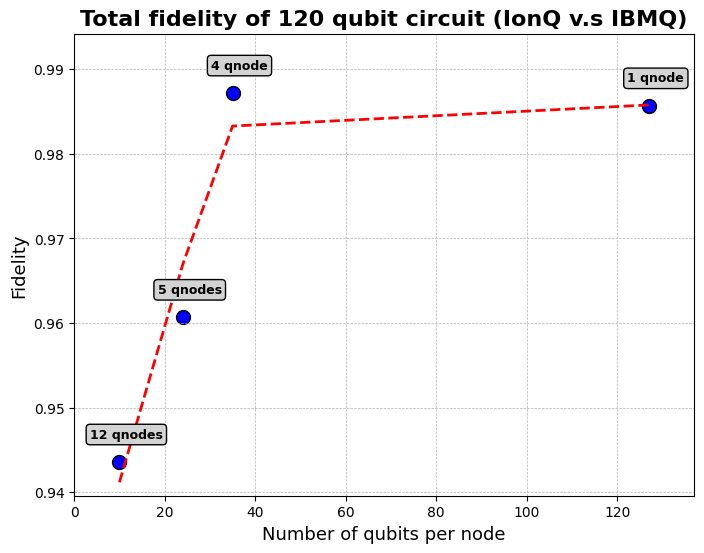

In [15]:
labels = ["12 qnodes", "5 qnodes", "4 qnode", "1 qnode"]

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(8, 6))

# Calcular la línea de tendencia
coefficients = np.polyfit(qubits_list, fidelity_list, 2)
trendline = np.poly1d(coefficients)

# Configuración del gráfico
ax.scatter(qubits_list, fidelity_list, color='blue', s=100, edgecolors='k', label='Datos')
ax.plot(qubits_list, trendline(qubits_list), color='red', linestyle='--', linewidth=2, label='Línea de tendencia')

# Añadir etiquetas a los puntos
for i, txt in enumerate(labels):
    ax.annotate(txt, (qubits_list[i], fidelity_list[i] + 0.002), textcoords="offset points", xytext=(5,5), ha='center',
                fontsize=9, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='lightgray'))

# Títulos y etiquetas
ax.set_title('Total fidelity of 120 qubit circuit (IonQ v.s IBMQ)', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of qubits per node', fontsize=13)
ax.set_ylabel('Fidelity', fontsize=13)

# Líneas de cuadrícula
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Get the x, y limits
xmin, xmax = min(qubits_list), max(qubits_list)
ymin, ymax = min(fidelity_list), max(fidelity_list)
plt.xlim(xmin-10, xmax+10)
plt.ylim(ymin-0.004, ymax + 0.007)

(76.37769999999995, 4483.312900000001)

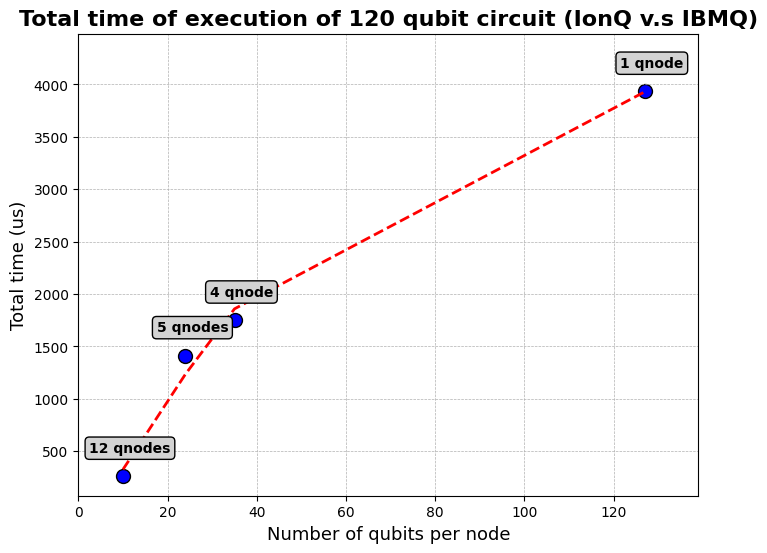

In [16]:
labels = ["12 qnodes", "5 qnodes", "4 qnode", "1 qnode"]
# Get the x, y limits
xmin, xmax = min(qubits_list), max(qubits_list)
ymin, ymax = min(timing_error_list), max(timing_error_list)
range_values_y = ymax - ymin

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(8, 6))

# Calcular la línea de tendencia
coefficients = np.polyfit(qubits_list, timing_error_list, 2)
trendline = np.poly1d(coefficients)

# Configuración del gráfico
ax.scatter(qubits_list, timing_error_list, color='blue', s=100, edgecolors='k', label='Datos')
ax.plot(qubits_list, trendline(qubits_list), color='red', linestyle='--', linewidth=2, label='Línea de tendencia')

# Añadir etiquetas a los puntos
for i, txt in enumerate(labels):
    ax.annotate(txt, (qubits_list[i], timing_error_list[i] + range_values_y * 0.045), textcoords="offset points", xytext=(5,5), ha='center',
                fontsize=10, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='lightgray'))

# Títulos y etiquetas
ax.set_title('Total time of execution of 120 qubit circuit (IonQ v.s IBMQ)', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of qubits per node', fontsize=13)
ax.set_ylabel('Total time (us)', fontsize=13)

# Líneas de cuadrícula
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.xlim(xmin-10, xmax+12)
plt.ylim(ymin - range_values_y * 0.05, ymax + range_values_y * 0.15)